In [423]:
#!pip install packagename
# importing modules
import geopandas as gpd
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os import chdir as cd
import time
import fiona
from datetime import date

In [424]:
US_states = gpd.read_file(r'D:\Work\Box Sync\Trends_all states\Maps_2020\tl_2020_us_state.zip')
US_states = US_states.to_crs('EPSG:9311')

# adding metropolitan/Micropolitan data
MSA_geo_20 = gpd.read_file(r'D:\Work\Box Sync\Trends_all states\Maps_2020\tl_2020_us_cbsa.zip')
MSA_Population_20 = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\Census Tract HUs\ACSDP5Y2020.DP05-Data.csv')
MSA_geo_20 = MSA_geo_20.to_crs('EPSG:9311')
MSA_geo_20.columns

MSA_Population =  MSA_Population_20[['GEO_ID', 'NAME', 'DP05_0001E']]
MSA_Population = MSA_Population.iloc[1:,:].reset_index(drop= True)
MSA_Population.rename({'DP05_0001E':'msa_population'}, axis =1, inplace = True)
MSA_Population['GEOID'] = MSA_Population['GEO_ID'].str[9:]
MSA_Population.columns

MSA_data = MSA_geo_20.merge(MSA_Population[['msa_population', 'GEOID']], on = 'GEOID')

# MSA_data.isna().sum()

In [425]:
'''
source: https://www2.census.gov/geo/pdfs/maps-data/data/tiger/tgrshp2019/TGRSHP2019_TechDoc.pdf
MTFCC: G4110 (incorporated place) and G4210 (census designated place)
PCICBSA: Current metropolitan or micropolitan statistical area principal city indicator
'''
# importing spatial data 
US_places =  gpd.read_file(r'D:\Work\Box Sync\Trends_all states\Maps_2020\compiled.shp')
US_places = US_places.to_crs('EPSG:9311')
US_places['PCICBSA'].value_counts()
# dropping columns that will not be used in the anaysis
places_US = US_places.drop(['PLACEFP', 'PLACENS', 'NAME', 'LSAD', 'CLASSFP',
                            'PCINECTA','FUNCSTAT', 'AWATER', 'INTPTLAT', 
                            'INTPTLON', ], axis =1)

# importing housing density calculated from Census Tract level, weighted by no of housing units
df_weighted_density = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\weighted_housingUnits_for_places.csv')
df_weighted_density['GEOID'] = df_weighted_density['GEOID_2'].astype(str).str.rjust(7, '0')


# merging spatial data with dataframe
places_weighted_housing = places_US.merge(df_weighted_density[['GEOID', 'weighted_HU_density']], 
                                          on = 'GEOID')
places_weighted_housing.shape, places_weighted_housing.columns

# importing current trend estimates and joining with geodataframe
mk_dataset = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\mktest_place_10-20_Continued_labeled.csv')
mk_dataset['GEOID'] = mk_dataset['GEO_ID'].str[9:]

mk_dataset.shape, places_US.shape, df_weighted_density.shape

# this dataframe contains spatial data, housing density and current trend
df_current_trend = places_weighted_housing.merge(mk_dataset[['P_20', 'label', 'density_km2', 'GEOID']], 
                                    on = 'GEOID', how = 'outer')

df_current_trend.columns, df_current_trend.isna().sum()

# adding future trend forecasts from another dataframe
expected_trend_df = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\expected_trend_2023-03-29.csv', index_col =0)
expected_trend_df['GEOID'] = expected_trend_df['GEOID'].astype(str).str.rjust(7, '0')


df_with_trend_forecast = df_current_trend.merge(expected_trend_df[['GEOID', 'State', 'NAME10', 'expected_trend_1', 'expected_trend_2',
                                                                   'expected_trend_3', 'expected_trend_4', 'expected_trend_5',]],
                                                on= 'GEOID', how = 'outer')

df_with_trend_forecast = df_with_trend_forecast.merge(US_states[['REGION', 'DIVISION', 'STATEFP']], on = 'STATEFP')

In [515]:
# df_with_trend_forecast.isna().sum()

In [516]:
# Adding MSA data to apply urban rural suburban conditions based on MSA population
if places_US.crs == MSA_data.crs:
    df_msa_overlayed = gpd.overlay(places_US, MSA_data, how='intersection')


C:\Users\uttar\AppData\Local\Temp\ipykernel_13628\150186935.py:3: UserWarning: `keep_geom_type=True` in overlay resulted in 2889 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  df_msa_overlayed = gpd.overlay(places_US, MSA_data, how='intersection')


In [517]:
# portion of area that is part of metro area
df_msa_overlayed['portion_area'] = df_msa_overlayed.area/ df_msa_overlayed['ALAND_1']

In [518]:
df_msa_overlayed.shape, df_msa_overlayed.columns

((24011, 21),
 Index(['STATEFP', 'GEOID_1', 'NAMELSAD_1', 'PCICBSA', 'MTFCC_1', 'ALAND_1',
        'CSAFP', 'CBSAFP', 'GEOID_2', 'NAME', 'NAMELSAD_2', 'LSAD', 'MEMI',
        'MTFCC_2', 'ALAND_2', 'AWATER', 'INTPTLAT', 'INTPTLON',
        'msa_population', 'geometry', 'portion_area'],
       dtype='object'))

In [519]:
df_msa = df_msa_overlayed.groupby('GEOID_1')[[ 'NAMELSAD_2', 'LSAD', 'msa_population', 'portion_area']].max().reset_index()

In [520]:
# df_msa[df_msa['portion_area'] <1].sort_values('portion_area')

In [529]:
df_0 = df_with_trend_forecast.merge(df_msa, left_on = 'GEOID', right_on = 'GEOID_1', how = 'outer')

In [530]:
# df_0.isna().sum()

In [531]:
df_0['msa_population'] = df_0['msa_population'].astype(float)

In [532]:
# df[df['PCICBSA'] == 'N']['msa_population'].isna().sum()
# df[(df['msa_population'] > 0) & (df['portion_area'] > 0.5)].sort_values('portion_area')

In [533]:
new_col = 'class_LU'
msa_population = 'msa_population'
population = 'P_20'
housingUnit_density = 'weighted_HU_density'
df = df_0.copy()
df[new_col] = " "

# Apply conditions for urban-suburban-rural
# source: https://bjs.ojp.gov/content/pub/pdf/cusrancvs.pdf
for i in df.index:
    if df.loc[i,'PCICBSA'] == 'Y':
        if (df.loc[i, msa_population] >= 500000) & (df.loc[i, housingUnit_density] >= 3000):
            df.loc[i, new_col] = 'urban'
        else:
            df.loc[i, new_col] = 'suburban'
            
    elif df.loc[i,'PCICBSA'] == 'N':
        if (df.loc[i, msa_population] >= 500000) & (df.loc[i, housingUnit_density] >= 4000) | (
            df.loc[i, population] >= 50000) & (df.loc[i, housingUnit_density] >= 5000) | (
            df.loc[i, population] >= 10000) & (df.loc[i, housingUnit_density] >= 10000):
            
            df.loc[i, new_col] = 'urban'
            
        elif (df.loc[i, msa_population] >= 50000) & (df.loc[i,'portion_area'] > 0.1): # 50000 population is the threshold between Metro and Micro
            df.loc[i, new_col] = 'suburban' # 0.398
        else:
            df.loc[i, new_col] = 'rural'

In [534]:
pd.set_option('display.max_rows', 10)
# df[(df['msa_population'] >=50000) & (df['LSAD'] == 'M1')][['STATEFP','NAMELSAD', 'PCICBSA',
#        'weighted_HU_density', 'P_20', 'NAMELSAD_2', 'LSAD', 'msa_population', 'portion_area', 'class_LU']].sort_values('portion_area').head(20)

In [535]:
df[df['class_LU'] == 'rural'][['STATEFP','NAMELSAD', 'PCICBSA',
       'weighted_HU_density', 'P_20', 'density_km2', 'NAMELSAD_2', 'LSAD', 
                               'msa_population', 'portion_area', 'class_LU']].sort_values('P_20').head(20750)

,STATEFP,NAMELSAD,PCICBSA,weighted_HU_density,P_20,density_km2,NAMELSAD_2,LSAD,msa_population,portion_area,class_LU
20514,38,Auburn CDP,N,-99.0,0.0,0.0,NaN,NaN,NaN,NaN,rural
896,02,Port Protection CDP,N,-99.0,0.0,0.0,NaN,NaN,NaN,NaN,rural
25885,46,Loomis CDP,N,-99.0,0.0,0.0,"Mitchell, SD Micro Area",M2,23313.0,1.000003,rural
4121,08,Valdez CDP,N,-99.0,0.0,0.0,NaN,NaN,NaN,NaN,rural
4123,08,Vernon CDP,N,-99.0,0.0,0.0,NaN,NaN,NaN,NaN,rural
...,...,...,...,...,...,...,...,...,...,...,...
32183,78,Coral Bay CDP,N,-99.0,NaN,NaN,NaN,NaN,NaN,NaN,rural
32184,78,Cruz Bay CDP,N,-99.0,NaN,NaN,NaN,NaN,NaN,NaN,rural
32185,78,Frederiksted Southeast CDP,N,-99.0,NaN,NaN,NaN,NaN,NaN,NaN,rural
32186,78,Red Hook CDP,N,-99.0,NaN,NaN,NaN,NaN,NaN,NaN,rural


In [536]:
df['REGION'] = df['REGION'].astype(str)
for i in range(len(df)):
    # print(i)
    if df.loc[i,'REGION'] == 1.0:
        df.loc[i,'REGION'] = 'Northeast'
    elif df.loc[i,'REGION'] == 2.0:
        df.loc[i,'REGION'] = 'Midwest' 
    elif df.loc[i,'REGION'] == 3.0:
        df.loc[i,'REGION'] = 'South'
    elif df.loc[i,'REGION'] == 4.0:
        df.loc[i,'REGION'] = 'West'
    else:
        df.loc[i,'REGION'] = 'Other'   

In [537]:
# df_0['REGION'].value_counts(), df['REGION'].value_counts()
df['class_LU'].value_counts() / df['class_LU'].value_counts().sum()

suburban    0.636511
rural       0.353144
urban       0.010345
Name: class_LU, dtype: float64

In [538]:
df.groupby(['class_LU'])['P_20'].sum() / df.groupby(['class_LU'])['P_20'].sum().sum()

class_LU
rural       0.042131
suburban    0.753664
urban       0.204205
Name: P_20, dtype: float64

In [539]:
df[(df['msa_population'] > 50000) & (df['portion_area'] > 1)].shape

(14708, 26)

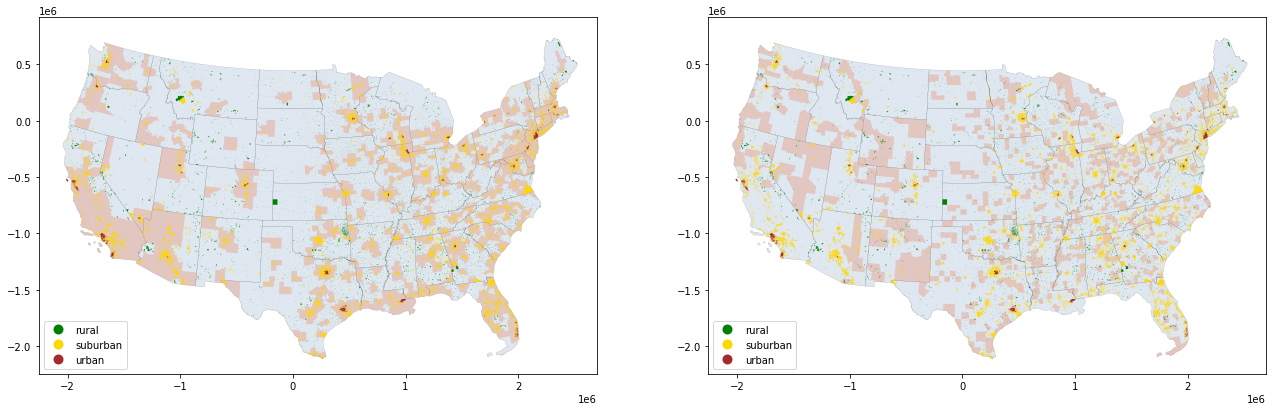

In [540]:
# to check if the intersected areas fall inside the MSAs
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(22,7))

metro_indicator = ['M1', 'M2']
for ax, metro in zip(ax.flatten(), metro_indicator):
    US_states.plot(ax=ax, facecolor = 'lightsteelblue', edgecolor='black', linewidth=0.2, alpha = 0.4)
    MSA_data[MSA_data['LSAD']==metro].plot(ax=ax, alpha = 0.4, color = 'darksalmon') # only metro areas 
    df.plot(ax= ax, column = 'class_LU',  legend = True, 
            legend_kwds={'loc': 'lower left'},
            cmap = matplotlib.colors.ListedColormap(['green','gold','brown',])) #  hatch='//'
    xlim = ([-2257388.37, 2695859.75]) 
    ylim = ([-2246944.04, 918095.9])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
# ax.set_facecolor('xkcd:ice') # https://xkcd.com/color/rgb/

In [503]:
# pd.set_option('display.max_rows', 10)
# df[df['class_LU'] == 'urban'][['STATEFP','NAMELSAD', 'NAMELSAD_2', 'label', 'density_km2',
#                                'P_20', 'msa_population', 'weighted_HU_density', 'class_LU']].sort_values('weighted_HU_density') #, ascending = False)

In [504]:
# fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,12))

# demo = df[(df['STATEFP'] == '36') & (df['portion_area'] > 2)]
# demo_place = places_US[(places_US['STATEFP'] == '36')]

# MSA_data[MSA_data['NAMELSAD'].str.contains('NY')].plot(ax=ax, facecolor = 'none', edgecolor='red', linewidth=0.2)# [MSA_data_20['LSAD']=='M1']
# demo.plot(ax= ax, column  = 'class_LU', legend = True)
# demo_place.plot(ax=ax, facecolor = 'none', edgecolor='grey', linewidth=0.2)


In [505]:
# # CHECK WHY portion AREA IS ABOVE 10 in some places?????????????????
# df[['STATEFP','NAMELSAD', 'NAMELSAD_2', 'label', 'density_km2','portion_area',
#     'P_20', 'msa_population', 'weighted_HU_density', 'class_LU']].sort_values('portion_area', ascending = False).head(500)

In [506]:
pd.crosstab(index=df.REGION, 
                          columns=[df['class_LU'], df['label'],]).sum(axis=1)
df[df['REGION'] == 'Not found']['REGION'].dtypes

dtype('O')

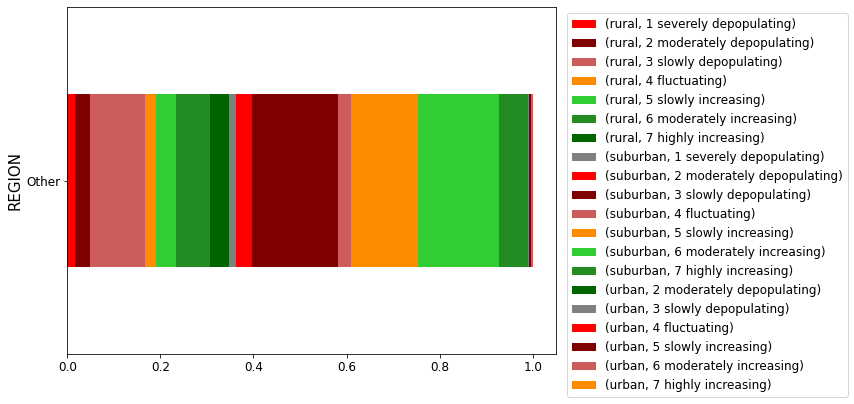

In [507]:
# checking data distribution
# plot for current trend and landuse
df_crosstab = pd.crosstab(index=df.REGION, 
                          columns=[df['class_LU'], df['label'], ],
                          normalize= 'index')  # {‘all’, ‘index’, ‘columns’},
df_crosstab

# color_names = ['red', 'maroon', 'indianred', 'darkorange', 'limegreen','forestgreen', 'darkgreen', 'gray']
# ['salmon', 'darkgoldenrod', 'greenyellow', 'tomato', 'goldenrod', 'yellowgreen', 'darksalmon', 'gold', 'palegreen', 'coral', 'tan', 'lightgreen']

ax = df_crosstab.plot(
    kind = 'barh',
    stacked = True,
    color = ['red', 'maroon', 'indianred', 'darkorange', 'limegreen','forestgreen', 'darkgreen', 'gray'],
    # title = '% Cities with population trend',
    mark_right = True,
    figsize=(12, 6))

# setting label sizes after creation
ax.yaxis.label.set_size(15)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(bbox_to_anchor=(1.01, 1.00), loc='upper left', prop={'size': 12})
plt.tight_layout()
plt.show()
fig = ax.get_figure()

#################################################################################
# # # plot for future trend and landuse
# df_crosstab = pd.crosstab(index=df['REGION'], 
#                           columns=[df['expected_trend_3'], 
#                                    df['class_LU']],
#                           normalize= 'index')

# ax = df_crosstab.plot(
#     kind = 'barh',
#     stacked = True,
#     color = ['tomato', 'indianred', 'coral', 'greenyellow', 'yellowgreen', 'palegreen', 'goldenrod',  'gold', 'tan'],
#     # title = '% Cities with population trend',
#     mark_right = True,
#     figsize=(12, 6))

# # setting label sizes after creation
# ax.yaxis.label.set_size(15)
# ax.tick_params(axis='both', which='major', labelsize=12)
# ax.legend(bbox_to_anchor=(1.01, 1.00), loc='upper left', prop={'size': 15})
# plt.tight_layout()
# plt.show()
# fig = ax.get_figure()

In [508]:
# places_weighted_housing[places_weighted_housing ['NAMELSAD'].str.contains('Casmalia')]
# US_urban = gpd.read_file(r'D:\Work\Box Sync\Trends_all states\Maps_2020\tl_2022_us_uac10.zip')
# US_urban = US_urban.to_crs('EPSG:9311')

In [509]:
df.groupby(['class_LU', 'expected_trend_3'])['class_LU'].count() *100 / df.groupby(['class_LU', 'expected_trend_3'])['class_LU'].count().sum()

class_LU  expected_trend_3
rural     decreasing          31.641894
          increasing           2.039405
          no trend             1.175251
suburban  decreasing          42.661597
          increasing          13.992395
          no trend             7.410992
urban     decreasing           0.494297
          increasing           0.407881
          no trend             0.176288
Name: class_LU, dtype: float64

In [510]:
output_path = r'D:\Work\Box Sync\Trends_all states\Output from Analysis\\'
output_file_name = 'demo_urban_sub_rural_'
df.to_csv(output_path + output_file_name + str(date.today()) + '.csv')

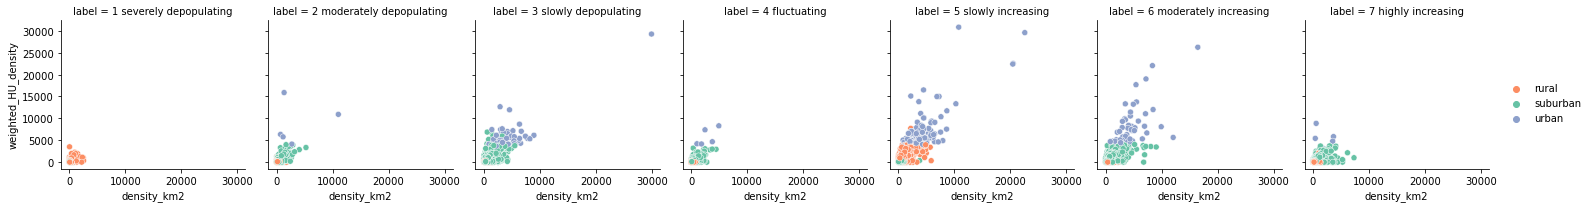

In [511]:
sns.set_palette("Set2", 7)
g = sns.FacetGrid(df.sort_values('label'), col="label", col_wrap=7)
g.map_dataframe(sns.scatterplot, 'density_km2', "weighted_HU_density", hue="class_LU",)
g.add_legend()

In [512]:
crosstabRes = pd.crosstab(index = df['class_LU'], columns = df['label'])
from scipy.stats import chi2_contingency
chisqRes =  chi2_contingency(crosstabRes)
print('P-value of the chi- squared test: ', chisqRes[1])
if chisqRes[1] < 0.05:
    print('The variables have correlation.')
else:
    print('not correlated')

P-value of the chi- squared test:  8.27132413112352e-228
The variables have correlation.


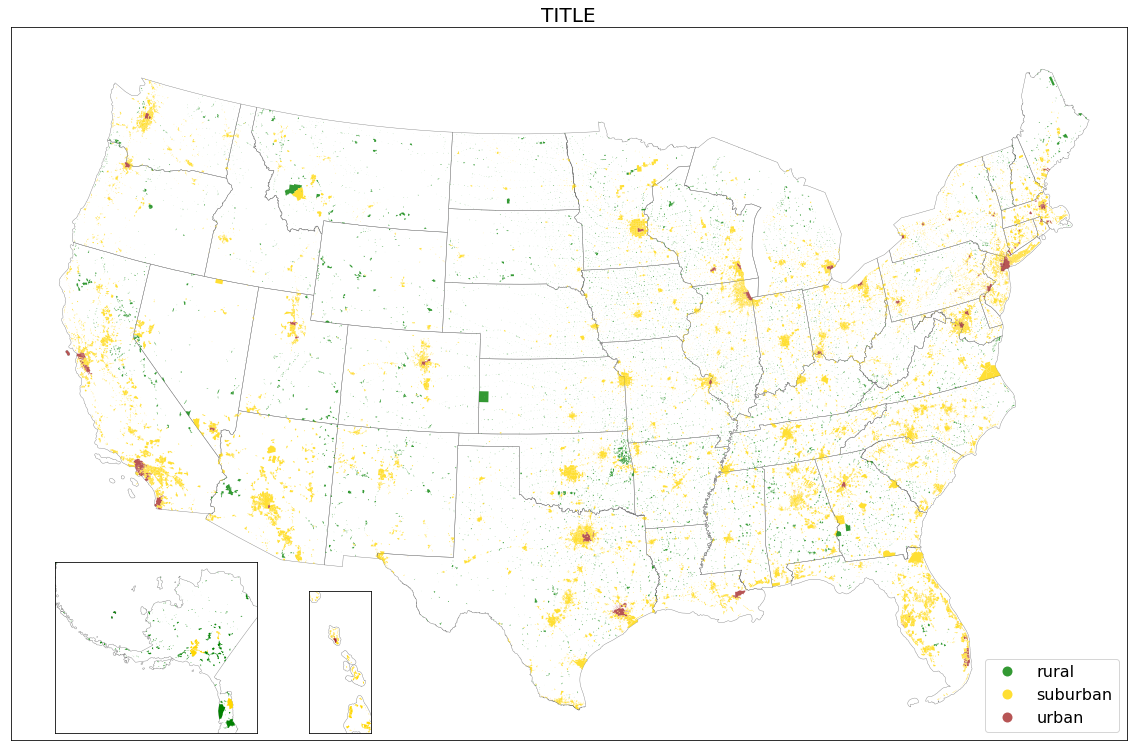

In [513]:
col = "class_LU"
cmap_color = matplotlib.colors.ListedColormap(['green','gold','brown',])

fig, continental_ax = plt.subplots(figsize=(20, 30))
alaska_ax = continental_ax.inset_axes([.01, .01, .24, .24])
hawaii_ax = continental_ax.inset_axes([.22, .01, .15, .20])

# Set bounds to fit desired areas in each plot
continental_ax.set_xlim(-2257388.37, 2695859.75)
continental_ax.set_ylim(-2246944.04, 918095.9)

alaska_ax.set_xlim(-4337634.21863075, -1564427.75408087)
alaska_ax.set_ylim(1528047.16872635, 3883917.63673733)

hawaii_ax.set_xlim(-5722090.887043, -5462538.83170424)
hawaii_ax.set_ylim(-1050846.93031638, -455238.37803499)

# Plot the data per area - requires passing the same choropleth parameters to each call
# because different data is used in each call, so automatically setting bounds won’t work
#vmin, vmax = df['ALAND'].agg(['min', 'max'])
US_states.plot(ax=continental_ax, facecolor = 'none', edgecolor='gray', linewidth=0.4)
df.plot(column=col, 
                                  ax=continental_ax,
                                  cmap=cmap_color,
                                  alpha = 0.8,
                                  legend = True,
                                  legend_kwds={'loc': 'lower right', 'fontsize': 16,}) #, vmin=vmin, vmax=vmax)

US_states.plot(facecolor = 'none', edgecolor='gray', linewidth=0.4, ax=alaska_ax)
df.plot(column=col, cmap=cmap_color, ax=alaska_ax) #, vmin=vmin, vmax=vmax)
US_states.plot(facecolor = 'none', edgecolor='gray', linewidth=0.4, ax=hawaii_ax)
df.plot(column=col, cmap=cmap_color, ax=hawaii_ax) #, vmin=vmin, vmax=vmax)

continental_ax.set_title('TITLE', fontsize=20, pad=5) 
#from ACS 5-yr population estimates using data from 2010-2020, (b) 

# remove ticks
for ax in [continental_ax, alaska_ax, hawaii_ax]:
    ax.set_yticks([])
    ax.set_xticks([])
    

<AxesSubplot:>

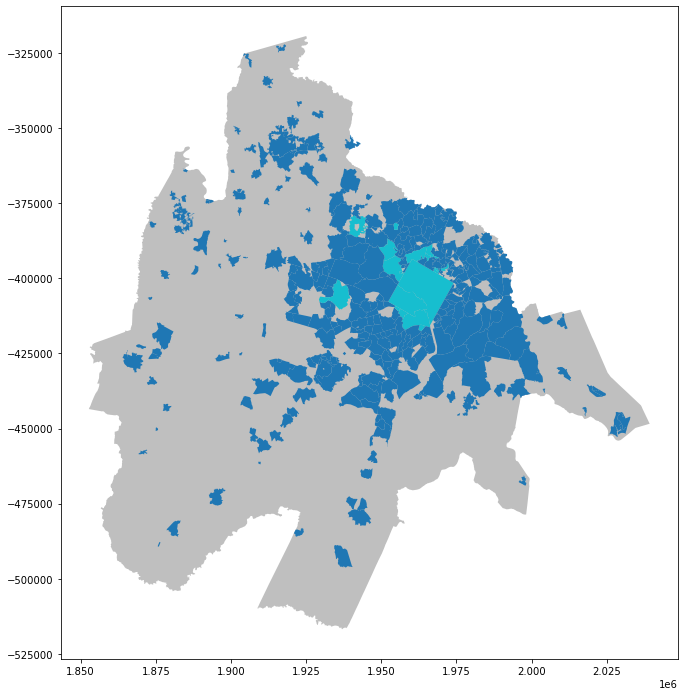

In [514]:
df_xx = df.dropna()
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(22,12))
MSA_data[MSA_data['NAMELSAD'].str.contains('DC')].plot(ax=ax, alpha = 0.5, color = 'gray')
df_xx[df_xx['NAMELSAD_2'].str.contains('DC')].plot(ax=ax,column = 'class_LU')

In [332]:
df_xx[df_xx['NAMELSAD_2'].str.contains('DC')][['STATEFP', 'GEOID', 'NAMELSAD', 'PCICBSA','NAMELSAD_2', 'msa_population', 'weighted_HU_density', 'P_20', 'class_LU']].sort_values('class_LU')

,STATEFP,GEOID,NAMELSAD,PCICBSA,NAMELSAD_2,msa_population,weighted_HU_density,P_20,class_LU
30583,54,5473444,Shenandoah Junction CDP,N,"Washington-Arlington-Alexandria, DC-VA-MD-WV M...",6250309.0,108.757900,1129.0,rural
29111,51,5105336,Bealeton CDP,N,"Washington-Arlington-Alexandria, DC-VA-MD-WV M...",6250309.0,79.679798,3964.0,rural
11766,24,2404650,Bartonsville CDP,N,"Washington-Arlington-Alexandria, DC-VA-MD-WV M...",6250309.0,139.549770,1786.0,rural
11760,24,2403500,Baden CDP,N,"Washington-Arlington-Alexandria, DC-VA-MD-WV M...",6250309.0,25.908436,1574.0,rural
12029,24,2462575,Point of Rocks CDP,N,"Washington-Arlington-Alexandria, DC-VA-MD-WV M...",6250309.0,73.139188,2067.0,rural
...,...,...,...,...,...,...,...,...,...
29330,51,5139064,Huntington CDP,N,"Washington-Arlington-Alexandria, DC-VA-MD-WV M...",6250309.0,8149.228461,13526.0,urban
11774,24,2407125,Bethesda CDP,Y,"Washington-Arlington-Alexandria, DC-VA-MD-WV M...",6250309.0,5045.639563,65092.0,urban
11894,24,2430800,Friendship Heights Village CDP,N,"Washington-Arlington-Alexandria, DC-VA-MD-WV M...",6250309.0,29366.073635,4577.0,urban
29519,51,5148450,McNair CDP,N,"Washington-Arlington-Alexandria, DC-VA-MD-WV M...",6250309.0,4842.334681,20776.0,urban


"\nFrom Rishabh's paper:\nZIP codes with a housing density ---------\nabove 2,213 households per square mile are classified as urban, \nthose between 102 to 2,213 households per square mile as suburban, and \nthose with fewer than 102 households per square mile as rural. \n"

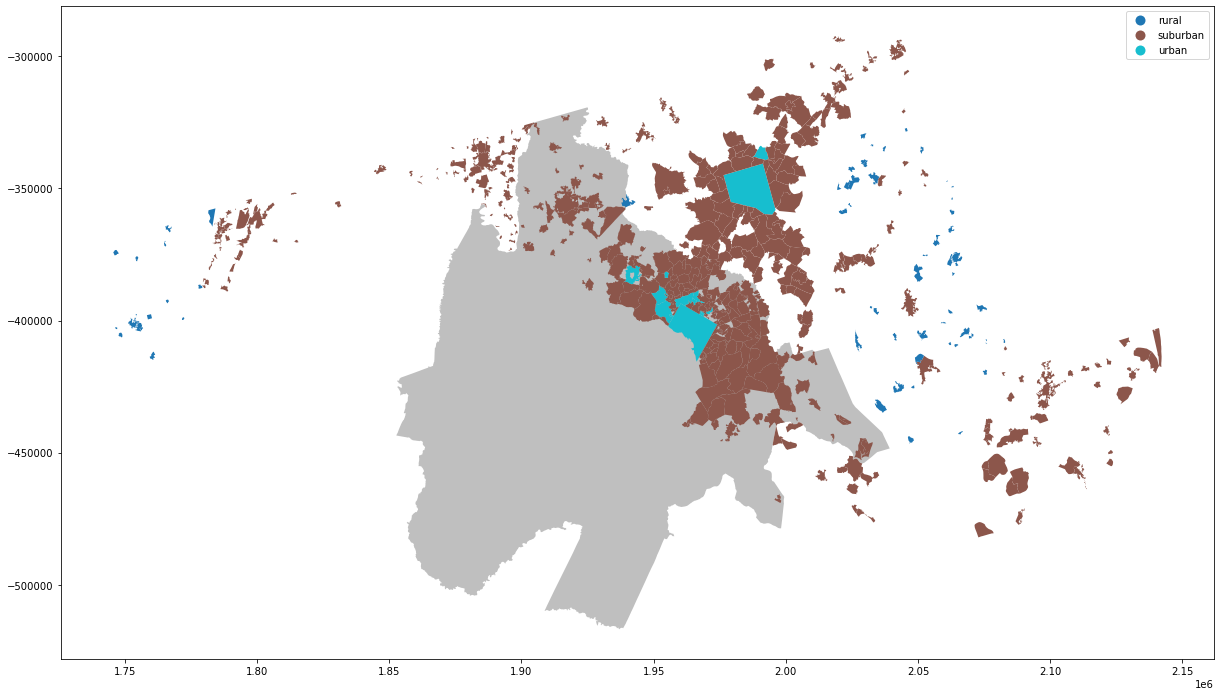

In [302]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(22,12))

# df_weighted_density.plot(ax=ax, alpha = 0.5, color = 'black') 
# msa_overlayed.plot(ax=ax, color = 'blue') 
MSA_data[MSA_data['NAMELSAD'].str.contains('DC')].plot(ax=ax, alpha = 0.5, color = 'gray') # [MSA_data_20['LSAD']=='M1']
df[(df['STATEFP'] == '11') | (df['STATEFP'] == '24')].plot(ax= ax, column  = 'class_LU', legend = True)

# xlim = ([-2257388.37, 2695859.75]) 
# ylim = ([-2246944.04, 918095.9])
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)

'''
From Rishabh's paper:
ZIP codes with a housing density ---------
above 2,213 households per square mile are classified as urban, 
those between 102 to 2,213 households per square mile as suburban, and 
those with fewer than 102 households per square mile as rural. 
'''

In [295]:
# df_xx = df.dropna()
# df_xx[['NAMELSAD', 'PCICBSA', 'weighted_HU_density', 'P_20', 
#        'NAMELSAD_2', 'msa_population',  'class_LU']].sort_values(['msa_population','weighted_HU_density'])
# # df_xx.columns

In [96]:
# 45*100/32188, 1222*100/32188, 30921*100/32188
# 300*100/32188, 1161*100/32188, 30921*100/32188

In [296]:
# new_col = 'class_LU'
# population = 'P_20'
# housingUnit_density = 'weighted_HU_density'
# df = df0.copy()
# df[new_col] = " "

# # Apply conditions for urban-suburban-rural
# # source: https://bjs.ojp.gov/content/pub/pdf/cusrancvs.pdf
# for i in df.index:
#     if df.loc[i,'PCICBSA'] == 'Y':
#         if (df.loc[i, population] >= 500000) & (df.loc[i, housingUnit_density] >= 3000) | (
#             df.loc[i, population] >= 50000) & (df.loc[i, housingUnit_density] >= 5000) | (
#             df.loc[i, population] >= 10000) & (df.loc[i, housingUnit_density] >= 10000):
            
#             df.loc[i, new_col] = 'urban'
#         else:
#             df.loc[i, new_col] = 'suburban'
            
#     elif df.loc[i,'PCICBSA'] == 'N':
#         if (df.loc[i, population] >= 500000) & (df.loc[i, housingUnit_density] >= 3000) | (
#             df.loc[i, population] >= 50000) & (df.loc[i, housingUnit_density] >= 5000) | (
#             df.loc[i, population] >= 10000) & (df.loc[i, housingUnit_density] >= 10000):
            
#             df.loc[i, new_col] = 'urban'
#     # elif df[(df[population] >= 500000) & (df[housingUnit_density] >= 4000)]:
#     #     df[new_col] = 'urban'
#         else:
#             df.loc[i, new_col] = 'rural'